In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

sys.path.append('..')
sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
import viz_2d as viz
import tiling_2d as tiling
import agg_2d as agg
import cd
import score_funcs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# get dataset
import pickle as pkl
from dsets.imagenet import dset
imnet_dict = pkl.load(open('../dsets/imagenet/imnet_dict.pkl', 'rb')) # contains 6 images (keys: 9, 10, 34, 20, 36, 32)

# get model
from torchvision import models
model = models.vgg16(pretrained=True).to(device).eval()
model_type='vgg' # alexnet, vgg

/system/linux/anaconda3.7/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/.xdg_cache_vision/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 89574001.51it/s] 


# cd propagation fig

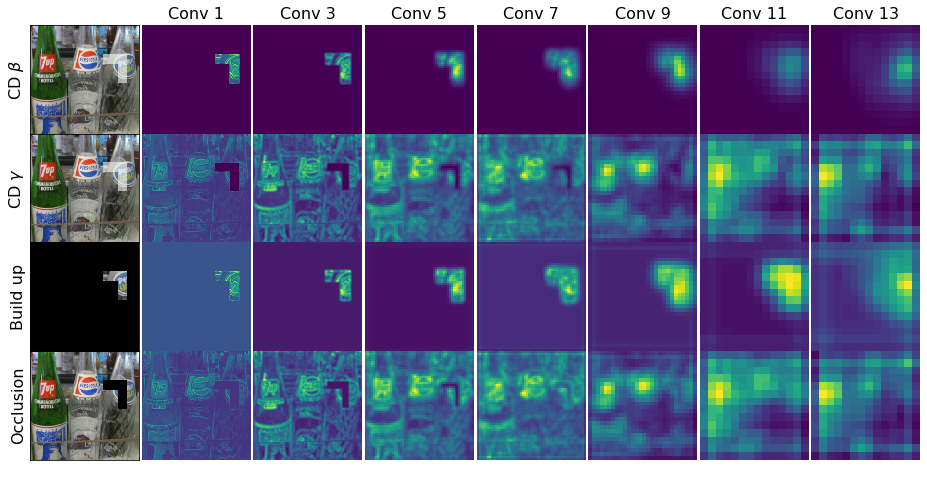

In [13]:
def vgg_track(im_torch, model):
    mods = list(model.modules())[2:]
    scores = []
    x = im_torch.clone()
    for i in range(30):
        x = mods[i](x)
        if i in [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]: # all the conv 2d layers
            scores.append(x.clone())
    return scores


# calculate cd score
f = 16
im_num = 23
im_torch, im_orig, label_num = dset.get_im_and_label(im_num) # remember torch is H x W x C

# set up blob
blob = np.zeros((3, 224, 224))
blob[:, 60:80, 150:200] = 1
blob[:, 60:120, 180:200] = 1

rel1, irrel1, scores = cd.cd_track_vgg(blob, im_torch, model)
scores = [scores[i] for i in np.arange(0, len(scores), 2)] # pick every other

# calculate build_up score
im_torch2, im_orig, label_num = dset.get_im_and_label(im_num) # remember torch is H x W x C
im_torch2[0, :, :60, :] = 0
im_torch2[0, :, :, :150] = 0
im_torch2[0, :, 80:120, :180] = 0
im_torch2[0, :, :, 200:] = 0
im_torch2[0, :, 120:, :] = 0
scores2 = vgg_track(im_torch2, model)
scores2 = [scores2[i] for i in np.arange(0, len(scores2), 2)] # pick every other

# calculate occlusion score
im_torch, im_orig, label_num = dset.get_im_and_label(im_num) # remember torch is H x W x C

im_torch[0, :, 60:80, 150:200] = 0
im_torch[0, :, 60:120, 180:200] = 0

scores3 = vgg_track(im_torch, model)
scores3 = [scores3[i] for i in np.arange(0, len(scores3), 2)] # pick every other

plt.figure(figsize=(16, 8))
num_rows = 4
num_cols = len(scores) + 1

# show original ims
# plt.subplot2grid((num_rows, num_cols), (0, 0), rowspan=num_rows)
# plt.gcf().text(0.18, 0.85, 'Blob', fontsize=14)
# plt.gcf().text(0.16, 0.15, 'Non-blob', fontsize=14)
plt.subplot(num_rows, num_cols, 1)
plt.imshow(im_orig)
blob_show = np.copy(blob[0])
blob_show[blob_show == 0] = np.nan
plt.imshow(blob_show, alpha=0.6, cmap='Greens')
plt.ylabel('CD $\\beta$', fontsize=f)
plt.xticks([])
plt.yticks([])


plt.subplot(num_rows, num_cols, num_cols + 1)
plt.imshow(im_orig, cmap='Greens')
plt.imshow(blob_show, alpha=0.6, cmap='Greens')
plt.ylabel('CD $\\gamma$', fontsize=f)
plt.xticks([])
plt.yticks([])

plt.subplot(num_rows, num_cols, num_cols * 3 + 1)
im_blob = np.copy(im_orig)
blob_idxs = blob.astype(np.int).transpose((1, 2, 0))
im_blob[blob_idxs] = 0
im_blob[60:80, 150:200] = 0
im_blob[60:120, 180:200] = 0
plt.imshow(im_blob)
plt.ylabel('Occlusion', fontsize=f)
plt.xticks([])
plt.yticks([])

plt.subplot(num_rows, num_cols, num_cols * 2 + 1)
im_blob = np.copy(im_orig)
blob_idxs = blob.astype(np.int).transpose((1, 2, 0))
# im_blob[blob_idxs] = 0
# im_blob[60:80, 150:200] = 0
# im_blob[60:120, 180:200] = 0

im_blob[:60, :] = 0
im_blob[:, :150] = 0
im_blob[80:120, :180] = 0
im_blob[:, 200:] = 0
im_blob[120:, :] = 0
plt.imshow(im_blob)
plt.ylabel('Build up', fontsize=f)
plt.xticks([])
plt.yticks([])

# show propagating images
for i in range(len(scores)):
    rel1, irrel1 = scores[i]
    x = np.squeeze(rel1.data.cpu().numpy())
    x = np.sum(np.abs(x), axis=0)

    y = np.squeeze(irrel1.data.cpu().numpy())
    y = np.sum(np.abs(y), axis=0)

    rel2 = scores2[i]
    z = np.squeeze(rel2.data.cpu().numpy())
    z = np.sum(np.abs(z), axis=0)

    rel3 = scores3[i]
    zz = np.squeeze(rel3.data.cpu().numpy())
    zz = np.sum(np.abs(zz), axis=0)
    
    vmax1, vmin1 = max(np.max(x), np.max(z)), min(np.min(x), np.min(z))
    vmax2, vmin2 = max(np.max(y), np.max(zz)), min(np.min(y), np.min(zz))

    # top row
    plt.subplot(num_rows, num_cols, i + 2)
    plt.imshow(x, interpolation='None', vmin=vmin1, vmax=vmax1)
    plt.axis('off')
    plt.title('Conv ' + str(2*i+1), fontsize=f)
    
    # plot 2
    plt.subplot(num_rows, num_cols, num_cols + i + 2)
    plt.imshow(y, interpolation='None', vmin=vmin2, vmax=vmax2)
    plt.axis('off')

    # plot 3
    plt.subplot(num_rows, num_cols, num_cols * 2 + i + 2)
    plt.imshow(z, interpolation='None', cmap='viridis', vmin=vmin1, vmax=vmax1)
    plt.axis('off')    

    # plot 4
    plt.subplot(num_rows, num_cols, num_cols * 3 + i + 2)
    plt.imshow(zz, interpolation='None', cmap='viridis', vmin=vmin2, vmax=vmax2)
    plt.axis('off')

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

# fig 3 - recreate hockey example

In [ ]:
# hyperparameters
num_iters = 5 # number of iterations to agglomerate before merging remaning blobs (fig uses 4)
percentile_include = 95 # values above this percentile will be added at each iteration (fig uses 95)
method = 'cd' # method to rank importance ('cd' works best, 'build_up' or 'occlusion' are simplest)
sweep_dim = 14 # importances are calculated by blocks of sweep_dim x sweep_dim (14 yields good results for imagenet)
im_torch, im_orig, lab_num_correct = imnet_dict[9] # the hockey example
lab_pred = np.argmax(dset.pred_ims(model, np.copy(im_orig)))

lists = agg.agglomerate(model, dset.pred_ims, percentile_include, method, sweep_dim, im_orig, 
                        lab_pred, num_iters=num_iters, im_torch=im_torch, model_type=model_type)        


# visualize
plt.figure(figsize=(12, 5), facecolor='white', dpi=100)
rows = 3      
num_ims = len(lists['scores_list'])

# original plots
ind, labs = viz.visualize_original_preds(im_orig, lab_num_correct, 
                                         lists['comp_scores_raw_list'], lists['scores_orig_raw'],
                                         subplot_rows=rows, dset=dset)

# comp plots
viz.visualize_ims_list(lists['comps_list'],
                      title='Chosen blobs',
                      subplot_row=1, subplot_rows=rows, colorbar=False, im_orig=im_orig, plot_overlay=True)

# dict plots
viz.visualize_dict_list_top(lists['comp_scores_raw_list'], method,
                       subplot_row=2, subplot_rows=rows, ind=ind, labs=labs, use_orig_top=True)

# fig s1 - compare different scores

In [ ]:
def get_diff_scores(im_torch, im_orig, label_num, model, preds, sweep_dim):
    scores = []

    # cd
    method = 'cd'
    tiles = tiling.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
    scores_cd = score_funcs.get_scores_2d(model, method=method, ims=tiles, 
                                   im_torch=im_torch, model_type=model_type, device=device)
    scores.append(scores_cd)
    for method in ['occlusion', 'build_up']: # 'build_up'
        tiles_break = tiling.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
        preds_break = score_funcs.get_scores_2d(model, method=method, ims=tiles_break, 
                                            im_torch=im_torch, pred_ims=dset.pred_ims)
        if method == 'occlusion':
            preds_break += preds
        scores.append(np.copy(preds_break))
    
    # get integrated gradients scores
    scores.append(score_funcs.ig_scores_2d(model, im_torch, num_classes=1000, 
                                           im_size=224, sweep_dim=sweep_dim, ind=[label_num], device=device))
    
    return scores



# pick an image + get scores
im_nums = [34, 20, 36, 32] # 34: screen, 20: snake, 36: trash can, 32: crane
sweep_dim = 14
# sweep_dim = 56
fig = plt.figure(figsize=(10, 8), facecolor='white')

for x, im_num in enumerate(im_nums):

    im_torch, im_orig, label_num = imnet_dict[im_num] # remember torch is H x W x C
    print('lab', dset.lab_dict[label_num])
    # viz.visualize_ims_tiled(tiling.gen_tiles(im_orig, fill=np.nan))
    preds = dset.pred_ims(model, im_orig).flatten()
    ind = np.argpartition(preds, -8)[-8:] # top-scoring indexes
    ind = ind[np.argsort(preds[ind])][::-1] # sort the indexes
    scores = get_diff_scores(im_torch, im_orig, label_num, model, preds, sweep_dim)

    # plot raw image
    num_rows = len(im_nums)
    num_cols = len(scores) + 1
    plt.subplot(num_rows, num_cols, 1 + x * num_cols)
    plt.imshow(im_orig)
#     plt.axis('off')
    plt.gca().xaxis.set_visible(False)
    plt.yticks([])
    if x == 0:
        plt.title('Image', fontsize=16)

    if x == 0:
        plt.ylabel('CRT screen', fontsize=15)
    elif x == 1:
        plt.ylabel('Green mamba', fontsize=15)
    elif x == 2:
        plt.ylabel('Trash can', fontsize=15)
    elif x == 3:
        plt.ylabel('Crane', fontsize=15)


    # plot scores
    vmax = max([np.max(scores[i]) for i in range(len(scores))])
    vmin = min([np.min(scores[i]) for i in range(len(scores))])
    vabs = max(abs(vmax), abs(vmin))
    for i, tit in enumerate(['CD', 'Occlusion', 'Build-Up', 'IG']):
        plt.subplot(num_rows, num_cols, 2 + i + x * num_cols)
        if i == 0:
            plt.ylabel('pred: ' + dset.lab_dict[ind[0]][:16] + '...', fontsize=15)     
        if x == 0:
            plt.title(tit, fontsize=16)
        p = viz.visualize_preds(scores[i], num=label_num, cbar=False) #axis_off=False,  vabs=vabs)
        plt.xticks([])
        plt.yticks([])
#     divider = make_axes_locatable(plt.gca())
#     cax = divider.append_axes("right", size="2%", pad=0.05)
#     plt.colorbar(p, cax=cax)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()